# Команда в фентэзи-лиге.
Цель данного проекта: построить оптимальный состав для участия в фентези-лиге интернет-портала [sports.ru](https://www.sports.ru/fantasy/football/) с помощью методов линейной оптимизации с ограничениями.

Вместе с этим данный проект сделан для того, чтобы отразить навыки сбора, обработки и анализа данных.

## Суть работы.
У каждого участника есть ограниченный бюджет, который он может использовать для покупки игроков. При этом есть другие ограничения, например, количество игроков определенной позиции или количество игроков одного клуба.

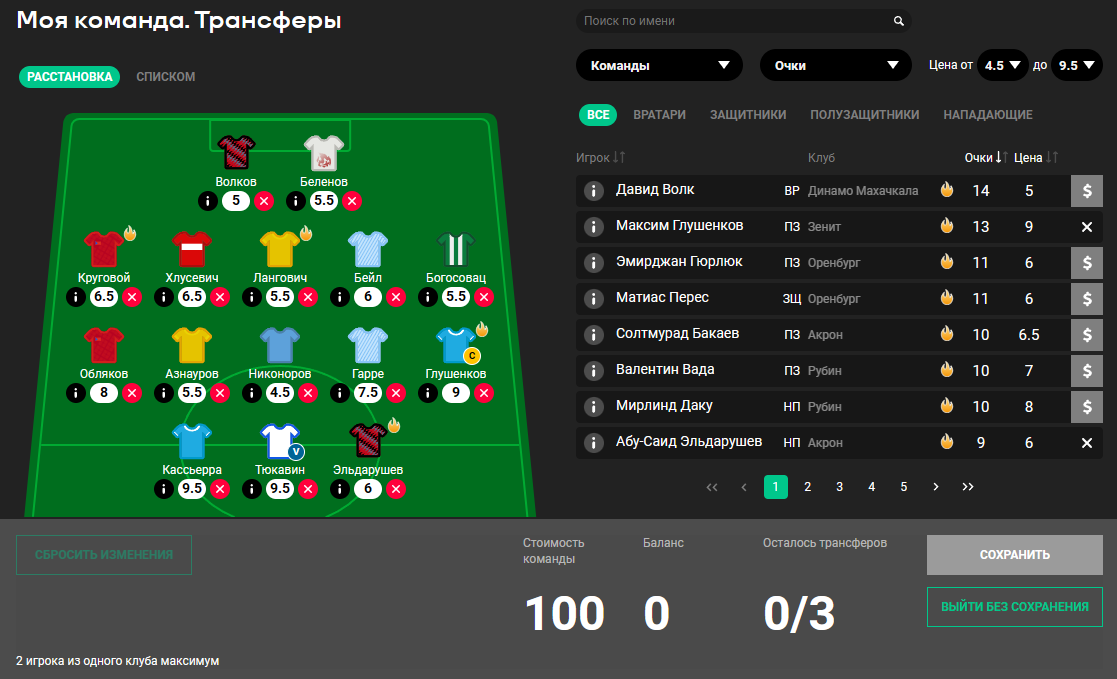

Каждый игрок в составе приносит определенное количество очков за определенное действие.

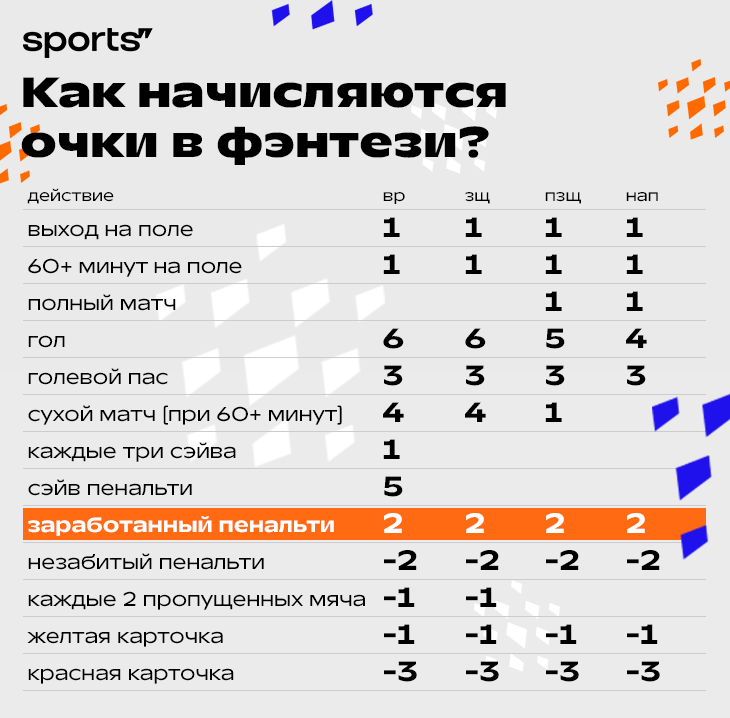

Таким образом, задача стоит в максимизации количества очков команды при определенных ограничениях.

## Описание задач
1. Собрать данные с помощью методов веб-скраппинга (selenium). 
2. Обработать их (pandas).
3. Максимизировать с ограничениями (pulp). 

## Сбор и обработка 
1. Получить список игроков с портала с их стоимостью, позицией и командой.
2. Получить имеющуюся статистику для подсчета очков.

In [50]:
#Импортируем библиотеки
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time
import pandas as pd
import keyring

In [51]:
#создаем переменные юзернейма и пароля аккаунта, зарегестрированного на портале, используя библиотеку keyring, чтобы скрыть персональные данные
username = keyring.get_password('sports.ru', 'mail')
password = keyring.get_password('sports.ru', 'password')
url = 'https://www.sports.ru/fantasy/football/russia/'

In [54]:
#работаем с настройкой парсинга и входим на страницу, с которой будем собирать данные
service = Service(executable_path=ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

driver.get(url)
time.sleep(3)

button_start = driver.find_element('xpath', "//input[@placeholder = 'Название твоей команды']")
button_start.click()
time.sleep(3)

mail_window = driver.find_element('xpath', "//input[@type='email']")
password_window = driver.find_element('xpath',
 "//input[@type = 'password']")

mail_window.send_keys(username)
time.sleep(3)
password_window.send_keys(password)
time.sleep(3)

button_enter = driver.find_element('xpath', "(//button[@type = 'button'])[3]")
button_enter.click()
time.sleep(10)

button_transfers = driver.find_element('xpath', "//button[@class = 'fantasy-substitutions__footer-btn fantasy-substitutions__footer-btn--transfers']")
button_transfers.click()


Попадаем на следующую страничку, где нам придется лисать списки с игроками и доставать данные поочередно
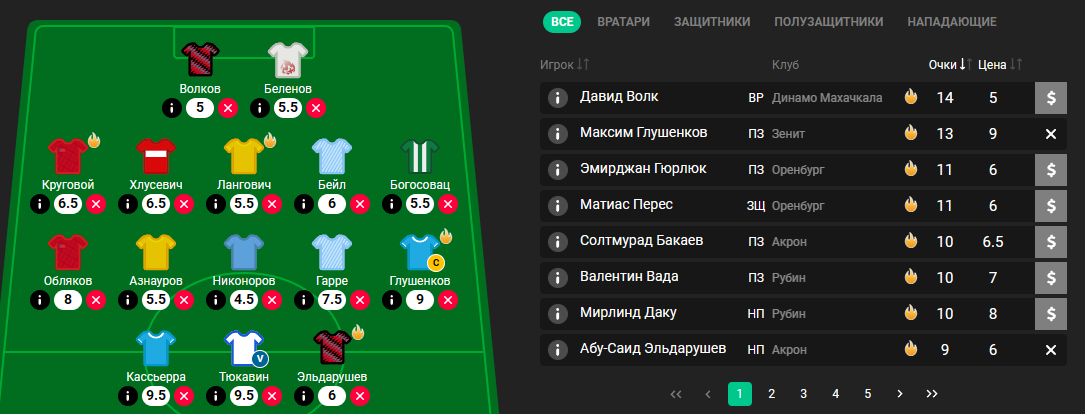

In [55]:
#достаем поочередно данные
button_next = driver.find_element('xpath', "//button[@class = 'page-button page-button--control page-button--control-next']")
i = 1

players_txt = ''

while i <= 57:
    time.sleep(3) 
    players_info = driver.find_element('xpath', "//div[@class = 'fantasy-players-list__list']")
    players_txt = players_txt + players_info.text
    if i < 57:
        i += 1
        players_txt = players_txt +'\n'
        button_next.click()
    else:
        break
driver.close()


In [89]:
#проверим данные и обработаем их
print(players_txt.replace('\n',' ')[:40])
players_list = players_txt.split('\n')
print(players_list[:5])
players_list_list = [players_list[i:i+5] for i in range(0, len(players_list), 5)]
print(players_list_list[:3])
players_df = pd.DataFrame(players_list_list, columns= ['Имя', 'Позиция', 'Команда', 'Очки', 'Цена']).drop('Очки', axis = 1)
print(players_df.head())

Максим Глушенков ПЗ Зенит 21 9 Давид Вол
['Максим Глушенков', 'ПЗ', 'Зенит', '21', '9']
[['Максим Глушенков', 'ПЗ', 'Зенит', '21', '9'], ['Давид Волк', 'ВР', 'Динамо Махачкала', '20', '5'], ['Вендел Вале', 'ПЗ', 'Зенит', '19', '8']]
                Имя Позиция           Команда Цена
0  Максим Глушенков      ПЗ             Зенит    9
1        Давид Волк      ВР  Динамо Махачкала    5
2       Вендел Вале      ПЗ             Зенит    8
3      Игорь Дивеев      ЗЩ              ЦСКА    6
4  Солтмурад Бакаев      ПЗ             Акрон  6.5


Далее будем работать с порталом [championat.ru](https://www.championat.com/football/_russiapl/tournament/5441/statistic/player/warning/) и доставать информацию о карточках, голевых передачах и голах

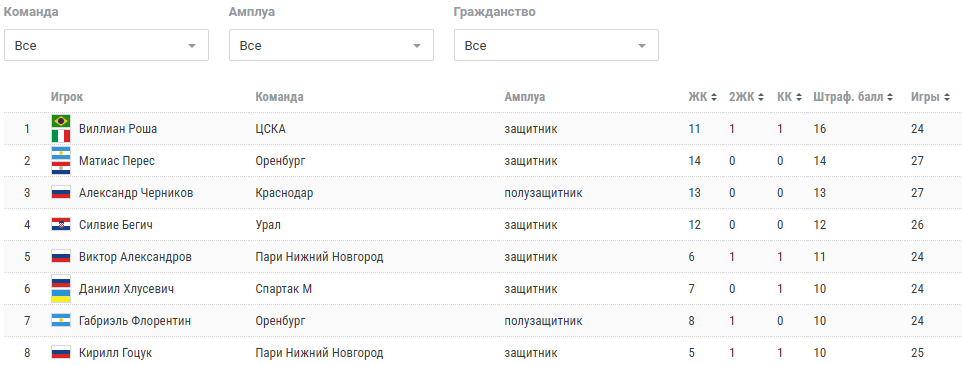

In [57]:
#у портала динамический поп-ап, который меняет информацию на сайте в зависимости от размера окна браузера, так что поменяем настройки браузера
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--window-size=1600,1000')
service = Service(executable_path=ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)
url = 'https://www.championat.com/football/_russiapl/tournament/5441/statistic/player/warning/'
driver.get(url)

cards_table = driver.find_element('xpath', '//table')
cards_str = cards_table.text

driver.close()

In [58]:
#достанем и обработаем данные
cards_list = cards_str.split('\n')[8:]
print(cards_list[:10])

cards_list_list = [cards_list[i:i+3] for i in range(0, len(cards_list),3)]
print(cards_list_list[:5])

cards_df = pd.DataFrame(cards_list_list, columns= ['№', 'Игрок', 'info'])

#здесь возникает проблема, что названия клубов содержат разное число слов, поэтому приходится переворачивать строку, чтобы метод split оставлял название команды в конце, а затем перевернем обратно
cards_df[cards_str.split('\n')[7:0:-1]] = cards_df['info'].str[::-1].str.split(pat=' ', n =6, expand= True)
cards_df[cards_str.split('\n')[7:0:-1]] = cards_df[cards_str.split('\n')[7:0:-1]].map(lambda x: str(x)[::-1])
cards_df = cards_df.drop(['info', '№'], axis = 1)
print(cards_df.head())

['1', 'Виллиан Роша', 'ЦСКА защитник 11 1 1 16 24', '2', 'Матиас Перес', 'Оренбург защитник 14 0 0 14 27', '3', 'Александр Черников', 'Краснодар полузащитник 13 0 0 13 27', '4']
[['1', 'Виллиан Роша', 'ЦСКА защитник 11 1 1 16 24'], ['2', 'Матиас Перес', 'Оренбург защитник 14 0 0 14 27'], ['3', 'Александр Черников', 'Краснодар полузащитник 13 0 0 13 27'], ['4', 'Силвие Бегич', 'Урал защитник 12 0 0 12 26'], ['5', 'Виктор Александров', 'Пари Нижний Новгород защитник 6 1 1 11 24']]
                Игрок Игры Штраф. балл КК 2ЖК  ЖК        Амплуа  \
0        Виллиан Роша   24          16  1   1  11      защитник   
1        Матиас Перес   27          14  0   0  14      защитник   
2  Александр Черников   27          13  0   0  13  полузащитник   
3        Силвие Бегич   26          12  0   0  12      защитник   
4  Виктор Александров   24          11  1   1   6      защитник   

                Команда  
0                  ЦСКА  
1              Оренбург  
2             Краснодар  
3        

In [59]:
#похожий алгоритм исполним с голевыми передачами и голами
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--window-size=1600,1000')
service = Service(executable_path=ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)
url = 'https://www.championat.com/football/_russiapl/tournament/5441/statistic/player/goalpass/'
driver.get(url)

goals_table = driver.find_element('xpath', '//table')
goals_str = goals_table.text

driver.close()

In [60]:
#обработаем данные
goals_list = goals_str.split('\n')[7:]
print(goals_list[:10])

goals_list_list = [goals_list[i:i+3] for i in range(0, len(goals_list),3)]
print(goals_list_list[:5])

goals_df = pd.DataFrame(goals_list_list, columns=['№', 'Имя', 'info'])
goals_df[goals_str.split('\n')[6:0:-1]] = goals_df['info'].str[::-1].str.split(pat=' ', n =5, expand= True)
goals_df[goals_str.split('\n')[6:0:-1]] = goals_df[goals_str.split('\n')[6:0:-1]].map(lambda x: str(x)[::-1])
goals_df = goals_df.drop(['info', '№'], axis = 1)
print(goals_df.head())

['1', 'Матео Кассьерра', 'Зенит нападающий 25 21 4 28', '2', 'Константин Тюкавин', 'Динамо М нападающий 24 15 9 30', '3', 'Максим Глушенков', 'Локомотив М нападающий 23 7 16 29', '4']
[['1', 'Матео Кассьерра', 'Зенит нападающий 25 21 4 28'], ['2', 'Константин Тюкавин', 'Динамо М нападающий 24 15 9 30'], ['3', 'Максим Глушенков', 'Локомотив М нападающий 23 7 16 29'], ['4', 'Джон Кордоба', 'Краснодар нападающий 18 15 3 27'], ['5', 'Фёдор Чалов', 'ЦСКА нападающий 15 12 3 29']]
                  Имя Игры Пасы Голы Гол+пас      Амплуа      Команда
0     Матео Кассьерра   28    4   21      25  нападающий        Зенит
1  Константин Тюкавин   30    9   15      24  нападающий     Динамо М
2    Максим Глушенков   29   16    7      23  нападающий  Локомотив М
3        Джон Кордоба   27    3   15      18  нападающий    Краснодар
4         Фёдор Чалов   29    3   12      15  нападающий         ЦСКА


Далее собираем информацию о вратарях с интернет-портала [soccer365.ru](https://soccer365.ru/competitions/13/2023-2024/players/&subt=keeper)

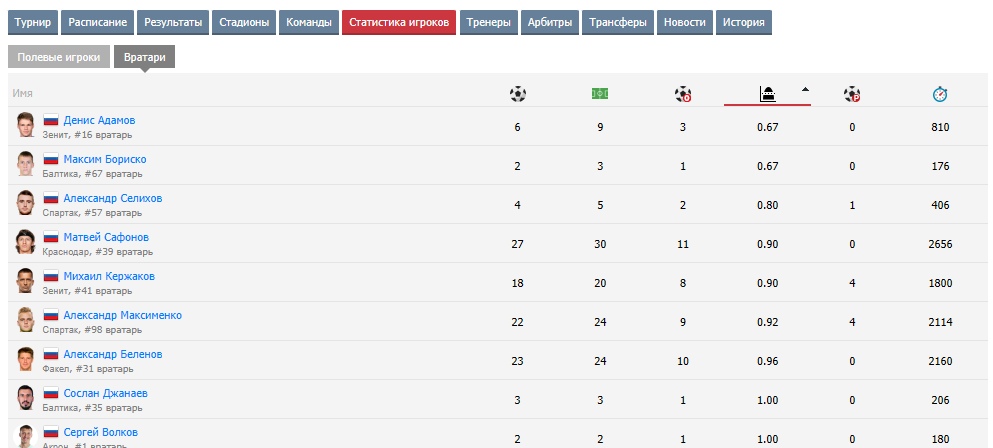

In [61]:
service = Service(executable_path=ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)
url = 'https://soccer365.ru/competitions/13/2023-2024/players/&subt=keeper'
driver.get(url)

keepers_table = driver.find_element('xpath', '//table')
keepers_str = keepers_table.text

driver.close()

In [62]:
keepers_list = keepers_str.split('\n')
keepers_list_list = [keepers_list[i:i+5] for i in range(0, len(keepers_list), 5)]
print(keepers_list_list)
keepers_df = pd.DataFrame(
    {'Имя': [keepers_list[i] for i in range(1, len(keepers_list), 4)],\
    'Команда': [keepers_list[i].split(',')[0] for i in range(3, len(keepers_list), 4)],
    'info': [keepers_list[i].split(',')[0] for i in range(4, len(keepers_list), 4)] }
)
keepers_df[['Пропущено мячей', 'Сыграно матчей', 'Сухие матчи', 'Пропущено голов за игру', 'Удалить']] = keepers_df['info'].str.split(pat=' ', n = 4, expand= True)
keepers_df = keepers_df.drop(['info', 'Удалить'], axis = 1)
print(keepers_df.head())

[['Имя', 'Денис Адамов', '', 'Зенит, #16 вратарь', '6 9 3 0.67 0 810'], ['Максим Бориско', '', 'Балтика, #67 вратарь', '2 3 1 0.67 0 176', 'Александр Селихов'], ['', 'Спартак, #57 вратарь', '4 5 2 0.80 1 406', 'Матвей Сафонов', ''], ['Краснодар, #39 вратарь', '27 30 11 0.90 0 2656', 'Михаил Кержаков', '', 'Зенит, #41 вратарь'], ['18 20 8 0.90 4 1800', 'Александр Максименко', '', 'Спартак, #98 вратарь', '22 24 9 0.92 4 2114'], ['Александр Беленов', '', 'Факел, #31 вратарь', '23 24 10 0.96 0 2160', 'Сослан Джанаев'], ['', 'Балтика, #35 вратарь', '3 3 1 1.00 0 206', 'Сергей Волков', ''], ['Акрон, #1 вратарь', '2 2 1 1.00 0 180', 'Иван Кукушкин', '', 'Пари Нижний Новгород, #81 вратарь'], ['1 1 0 1.00 0 90', 'Александр Дегтев', '', 'ПФК Сочи, #35 вратарь', '1 1 0 1.00 0 90'], ['Владислав Тороп', '', 'ЦСКА Москва, #49 вратарь', '6 5 1 1.20 1 450', 'Юрий Дюпин'], ['', 'Рубин, #22 вратарь', '35 29 9 1.21 1 2610', 'Илья Лантратов', ''], ['Локомотив Москва, #22 вратарь', '38 30 8 1.27 7 2700', '

К сожалению, оставшуюся статистику (сухие матчи защитников и полузащитников, заработанные пенальти, отраженные пенальти, незабитые пенальти) не удалось найти, так что приступим к корректировке таблиц и их объединению.

In [63]:
#сохраним промежуточные результаты
players_df.to_excel('players_df.xlsx', index= False)
goals_df.to_excel('goals_df.xlsx', index= False)
keepers_df.to_excel('keepers_df.xlsx', index= False)
cards_df.to_excel('cards_df.xlsx', index= False)

# Изучаем датафреймы, обрабатываем, стандартизируем и объединяем данные

In [ ]:
players_df = pd.read_excel('players_df.xlsx')
goals_df = pd.read_excel('goals_df.xlsx')
keepers_df = pd.read_excel('keepers_df.xlsx')
cards_df = pd.read_excel('cards_df.xlsx')


In [64]:
print(players_df.info())
print(players_df.head(5))
print(players_df[players_df['Имя'].duplicated(keep = False)])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Имя      453 non-null    object
 1   Позиция  453 non-null    object
 2   Команда  453 non-null    object
 3   Цена     453 non-null    object
dtypes: object(4)
memory usage: 14.3+ KB
None
                Имя Позиция           Команда Цена
0  Максим Глушенков      ПЗ             Зенит    9
1        Давид Волк      ВР  Динамо Махачкала    5
2       Вендел Вале      ПЗ             Зенит    8
3      Игорь Дивеев      ЗЩ              ЦСКА    6
4  Солтмурад Бакаев      ПЗ             Акрон  6.5
               Имя Позиция Команда Цена
45   Сергей Волков      ВР   Акрон    5
234  Сергей Волков      ЗЩ   Зенит    6


In [65]:
#сменю название позиций, чтобы было более наглядно
players_df['Позиция'] = players_df['Позиция'].replace(
    {'ВР': 'вратарь',
    'ПЗ': 'полузащитник',
    'ЗЩ': 'защитник',
    'НП': 'нападающий'}
)
players_df.head(5)

,Имя,Позиция,Команда,Цена
0,Максим Глушенков,полузащитник,Зенит,9
1,Давид Волк,вратарь,Динамо Махачкала,5
2,Вендел Вале,полузащитник,Зенит,8
3,Игорь Дивеев,защитник,ЦСКА,6
4,Солтмурад Бакаев,полузащитник,Акрон,6.5


In [66]:
print(goals_df.info())
print(goals_df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Имя      262 non-null    object
 1   Игры     262 non-null    object
 2   Пасы     262 non-null    object
 3   Голы     262 non-null    object
 4   Гол+пас  262 non-null    object
 5   Амплуа   262 non-null    object
 6   Команда  262 non-null    object
dtypes: object(7)
memory usage: 14.5+ KB
None
                  Имя Игры Пасы Голы Гол+пас      Амплуа      Команда
0     Матео Кассьерра   28    4   21      25  нападающий        Зенит
1  Константин Тюкавин   30    9   15      24  нападающий     Динамо М
2    Максим Глушенков   29   16    7      23  нападающий  Локомотив М
3        Джон Кордоба   27    3   15      18  нападающий    Краснодар
4         Фёдор Чалов   29    3   12      15  нападающий         ЦСКА


In [ ]:
print(keepers_df.info())
print(keepers_df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Имя                      39 non-null     object 
 1   Команда                  39 non-null     object 
 2   Пропущено мячей          39 non-null     int64  
 3   Сыграно матчей           39 non-null     int64  
 4   Сухие матчи              39 non-null     int64  
 5   Пропущено голов за игру  39 non-null     float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.0+ KB
None
                 Имя    Команда  Пропущено мячей  Сыграно матчей  Сухие матчи  \
0       Денис Адамов      Зенит                6               9            3   
1     Максим Бориско    Балтика                2               3            1   
2  Александр Селихов    Спартак                4               5            2   
3     Матвей Сафонов  Краснодар               27              30           

In [67]:
#добавлю позицию, чтобы при объединении учесть дупликаты
keepers_df['Позиция'] = 'вратарь'

In [68]:
cards_df.rename(columns={'Игрок': 'Имя'}, inplace=True)
print(cards_df.info())
print(cards_df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Имя          325 non-null    object
 1   Игры         325 non-null    object
 2   Штраф. балл  325 non-null    object
 3   КК           325 non-null    object
 4   2ЖК          325 non-null    object
 5   ЖК           325 non-null    object
 6   Амплуа       325 non-null    object
 7   Команда      325 non-null    object
dtypes: object(8)
memory usage: 20.4+ KB
None
                  Имя Игры Штраф. балл КК 2ЖК  ЖК        Амплуа  \
0        Виллиан Роша   24          16  1   1  11      защитник   
1        Матиас Перес   27          14  0   0  14      защитник   
2  Александр Черников   27          13  0   0  13  полузащитник   
3        Силвие Бегич   26          12  0   0  12      защитник   
4  Виктор Александров   24          11  1   1   6      защитник   

                Команда  
0          

In [69]:
#используем библиотеку fuzzywuzzy, чтобы отыскать похожие, но разные значения, чтобы понять, как отредактировать датафреймы, не потеряв значений

from fuzzywuzzy import process

def find_best_matches(name, choices):
    matches = process.extract(name, choices)
    best_matches = [match[0] for match in matches if match[1] > 80 and name != match[0]]
    return best_matches[0] if best_matches else None # Возвращаем None, если список пустой

players_df['similar_name_cards'] = players_df['Имя'].apply(lambda x: find_best_matches(x, cards_df['Имя']))
print(players_df[~players_df['similar_name_cards'].isna()][['Имя', 'similar_name_cards']])



                       Имя similar_name_cards
2              Вендел Вале             Вендел
7         Дмитрий Воробьев   Дмитрий Воробьёв
8    Виллиан да Силва Роша       Виллиан Роша
9             Муми Нгамале       Муми Нгамалё
22                  Мойзес       Виктор Мозес
..                     ...                ...
428       Мауро Луна Диале         Диего Луна
432         Артем Тимофеев     Артём Тимофеев
437           Артур Юсупов              Артур
439          Макаров Денис      Денис Макаров
447           Джоэл Фамейе      Джоэль Фамейе

[79 rows x 2 columns]


In [70]:
#заменим в датафреймах ё на е
cards_df['Имя'] = cards_df['Имя'].str.replace('ё', 'е')
goals_df['Имя'] = goals_df['Имя'].str.replace('ё', 'е')
keepers_df['Имя'] = keepers_df['Имя'].str.replace('ё', 'е')

players_df['similar_name_cards'] = players_df['Имя'].apply(lambda x: find_best_matches(x, cards_df['Имя']))
print(players_df[~players_df['similar_name_cards'].isna()][['Имя', 'similar_name_cards']])

                       Имя similar_name_cards
2              Вендел Вале             Вендел
8    Виллиан да Силва Роша       Виллиан Роша
22                  Мойзес       Виктор Мозес
26           Дуглас Сантос  Дуглас дос Сантос
30           Франко Орозко      Франко Ороско
..                     ...                ...
419       Владимир Хубулов    Владимир Обухов
428       Мауро Луна Диале         Диего Луна
437           Артур Юсупов              Артур
439          Макаров Денис      Денис Макаров
447           Джоэл Фамейе      Джоэль Фамейе

[71 rows x 2 columns]


In [71]:
#сохранили только 8 наблюдений, попробуем найти такой процент точности в fuzzywuzzy, чтобы сохранить как можно больше, но при этом не переусердствовать
#выборка не такая большая, поэтому можно проанализировать
def find_best_matches(name, choices):
    matches = process.extract(name, choices)
    best_matches = [match[0] for match in matches if match[1] > 94 and name != match[0]]
    return best_matches[0] if best_matches else None # Возвращаем None, если список пустой

players_df['similar_name_cards'] = players_df['Имя'].apply(lambda x: find_best_matches(x, cards_df['Имя']))
print(players_df[~players_df['similar_name_cards'].isna()][['Имя', 'similar_name_cards']])

players_df['similar_name_keepers'] = players_df['Имя'].apply(lambda x: find_best_matches(x, keepers_df['Имя']))
players_df['similar_name_goals'] = players_df['Имя'].apply(lambda x: find_best_matches(x, goals_df['Имя']))

print(players_df[~players_df['similar_name_keepers'].isna()][['Имя', 'similar_name_keepers']])
print(players_df[~players_df['similar_name_goals'].isna()][['Имя', 'similar_name_goals']])


                           Имя similar_name_cards
26               Дуглас Сантос  Дуглас дос Сантос
75                 Милан Гайич         Милан Гаич
190               Саша Здьелар        Саша Зделар
265  Кристофер Мартинс Перейра  Кристофер Мартинс
294           Абдулла Багамаев    Абдула Багамаев
370             Матео Стаматов    Маттео Стаматов
439              Макаров Денис      Денис Макаров
447               Джоэл Фамейе      Джоэль Фамейе
Empty DataFrame
Columns: [Имя, similar_name_keepers]
Index: []
                           Имя similar_name_goals
26               Дуглас Сантос  Дуглас дос Сантос
75                 Милан Гайич         Милан Гаич
190               Саша Здьелар        Саша Зделар
265  Кристофер Мартинс Перейра  Кристофер Мартинс
439              Макаров Денис      Денис Макаров
447               Джоэл Фамейе      Джоэль Фамейе


In [72]:
#заменим данные значения в исходных датафреймах

name_map_cards = players_df[~players_df['similar_name_cards'].isna()][['Имя', 'similar_name_cards']]
name_map_goals = players_df[~players_df['similar_name_goals'].isna()][['Имя', 'similar_name_goals']]

def replace_name(name):
    matching_row = name_map_cards[name_map_cards['similar_name_cards'] == name]['Имя']
    if not matching_row.empty:
        return matching_row.iloc[0]
    else:
        return name


cards_df['Имя'] = cards_df['Имя'].apply(replace_name)
goals_df['Имя'] = goals_df['Имя'].apply(replace_name)

#проверим
print(cards_df[cards_df['Имя'] == 'Милан Гайич'])

            Имя Игры Штраф. балл КК 2ЖК ЖК    Амплуа Команда
40  Милан Гайич   26           6  1   0  3  защитник    ЦСКА


In [82]:
#объединим датафреймы
print(keepers_df.info())
final_df = players_df.merge(keepers_df[['Имя', 'Сыграно матчей', 'Сухие матчи', 'Пропущено голов за игру', 'Позиция']], how='left', on = ['Имя', 'Позиция'])
final_df = final_df.merge(cards_df[['Имя', 'Игры', 'ЖК', 'КК']], how = 'left', on = ['Имя'])
final_df = final_df.merge(goals_df[['Имя', 'Игры', 'Пасы', 'Голы']], how = 'left', on = ['Имя'])

print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Имя                      39 non-null     object
 1   Команда                  39 non-null     object
 2   Пропущено мячей          39 non-null     object
 3   Сыграно матчей           39 non-null     object
 4   Сухие матчи              39 non-null     object
 5   Пропущено голов за игру  39 non-null     object
 6   Позиция                  39 non-null     object
dtypes: object(7)
memory usage: 2.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Имя                      456 non-null    object
 1   Позиция                  456 non-null    object
 2   Команда                  456 non-null    object
 3   Ц

In [83]:
#заменим столбцы с кол-вом игр на один и удалим пустые записи, посмотрим, сколько останется наблюдений
final_df['Сыграно матчей'] = final_df['Сыграно матчей'].fillna(final_df['Игры_x']).fillna(final_df['Игры_y'])
final_df = final_df[final_df['Сыграно матчей'].notna()]


print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 258 entries, 0 to 455
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Имя                      258 non-null    object
 1   Позиция                  258 non-null    object
 2   Команда                  258 non-null    object
 3   Цена                     258 non-null    object
 4   similar_name_cards       8 non-null      object
 5   similar_name_keepers     0 non-null      object
 6   similar_name_goals       6 non-null      object
 7   Сыграно матчей           258 non-null    object
 8   Сухие матчи              27 non-null     object
 9   Пропущено голов за игру  27 non-null     object
 10  Игры_x                   222 non-null    object
 11  ЖК                       222 non-null    object
 12  КК                       222 non-null    object
 13  Игры_y                   187 non-null    object
 14  Пасы                     187 non-null    object

In [84]:
final_df = final_df.drop(['Игры_x', 'Игры_y', 'similar_name_cards', 'similar_name_keepers','similar_name_goals'], axis = 1) 
final_df = final_df.fillna(0)
final_df[['Сыграно матчей', 'Сухие матчи', 'ЖК', 'КК', 'Пасы', 'Голы']] = final_df[['Сыграно матчей', 'Сухие матчи', 'ЖК', 'КК', 'Пасы', 'Голы']].astype(int)
final_df[['Цена', 'Пропущено голов за игру']] = final_df[['Цена', 'Пропущено голов за игру']].astype(float)

Осталось 258 из 454, что достаточно неплохо, учитывая уход 3х команд в другую лигу и приход 3х новых команд и отсутствие статистики.

In [85]:
#дообработаем данные и добавим столбец с кол-вом очков


final_df['Очки'] = final_df['Сыграно матчей']*2 + final_df['Сухие матчи']*4 + (final_df['Пропущено голов за игру']//2)*(-1) + \
    final_df['ЖК']*(-1) + final_df['КК']*(-3) + final_df['Пасы']*3 + final_df['Голы'] * final_df['Позиция'].map({'нападающий': 4,'полузащитник': 5,'защитник': 6, 'вратарь': 6})

final_df['Очки на цену'] = final_df['Очки']/final_df['Цена']
    
print(final_df.head())

                Имя       Позиция    Команда  Цена  Сыграно матчей  \
0  Максим Глушенков  полузащитник      Зенит   9.0              29   
3      Игорь Дивеев      защитник       ЦСКА   6.0              10   
5           Бителло  полузащитник     Динамо   8.5              23   
6      Матиас Перес      защитник   Оренбург   6.0              27   
7  Дмитрий Воробьев    нападающий  Локомотив   7.5              24   

   Сухие матчи  Пропущено голов за игру  ЖК  КК  Пасы  Голы   Очки  \
0            0                      0.0   5   0    16     7  136.0   
3            0                      0.0   2   1     0     0   15.0   
5            0                      0.0   1   0     2     8   91.0   
6            0                      0.0  14   0     0     7   82.0   
7            0                      0.0   4   0     1     8   79.0   

   Очки на цену  
0     15.111111  
3      2.500000  
5     10.705882  
6     13.666667  
7     10.533333  


In [86]:
final_df.to_excel('final_df.xlsx', index= False)

In [87]:
print(final_df.head())

                Имя       Позиция    Команда  Цена  Сыграно матчей  \
0  Максим Глушенков  полузащитник      Зенит   9.0              29   
3      Игорь Дивеев      защитник       ЦСКА   6.0              10   
5           Бителло  полузащитник     Динамо   8.5              23   
6      Матиас Перес      защитник   Оренбург   6.0              27   
7  Дмитрий Воробьев    нападающий  Локомотив   7.5              24   

   Сухие матчи  Пропущено голов за игру  ЖК  КК  Пасы  Голы   Очки  \
0            0                      0.0   5   0    16     7  136.0   
3            0                      0.0   2   1     0     0   15.0   
5            0                      0.0   1   0     2     8   91.0   
6            0                      0.0  14   0     0     7   82.0   
7            0                      0.0   4   0     1     8   79.0   

   Очки на цену  
0     15.111111  
3      2.500000  
5     10.705882  
6     13.666667  
7     10.533333  


## Приступим к анализу данных и поиску оптимальной команды

In [88]:
import pulp

model = pulp.LpProblem("Fantasy_Football_Optimization", pulp.LpMaximize)

player_vars = pulp.LpVariable.dicts("Player", final_df.index, 0, 1, pulp.LpInteger)

model += pulp.lpSum([final_df['Очки'][i] * player_vars[i] for i in final_df.index]), "Total_Points_Per_Price"

model += pulp.lpSum([final_df['Цена'][i] * player_vars[i] for i in final_df.index]) <= 75, "Budget_Constraint"
model += pulp.lpSum([player_vars[i] for i in final_df.index if final_df['Позиция'][i] == 'вратарь']) == 1, "Goalkeeper_Constraint"
model += pulp.lpSum([player_vars[i] for i in final_df.index if final_df['Позиция'][i] == 'защитник']) >= 3, "Defender_Min_Constraint"
model += pulp.lpSum([player_vars[i] for i in final_df.index if final_df['Позиция'][i] == 'защитник']) <= 4, "Defender_Max_Constraint"
model += pulp.lpSum([player_vars[i] for i in final_df.index if final_df['Позиция'][i] == 'полузащитник']) >= 3, "Midfielder_Min_Constraint"
model += pulp.lpSum([player_vars[i] for i in final_df.index if final_df['Позиция'][i] == 'полузащитник']) <= 4, "Midfielder_Max_Constraint"
model += pulp.lpSum([player_vars[i] for i in final_df.index if final_df['Позиция'][i] == 'нападающий']) >= 2, "Forward_Min_Constraint"
model += pulp.lpSum([player_vars[i] for i in final_df.index if final_df['Позиция'][i] == 'нападающий']) <= 3, "Forward_Max_Constraint"
model += pulp.lpSum([player_vars[i] for i in final_df.index]) == 11, "Total_Players_Constraint"
for team in final_df['Команда'].unique():
    model += pulp.lpSum([player_vars[i] for i in final_df.index if final_df['Команда'][i] == team]) <= 2, f"Max_Players_From_{team}"

model.solve()

print("Status:", pulp.LpStatus[model.status])
print("Optimal total points per price:", pulp.value(model.objective))

if pulp.LpStatus[model.status] == 'Optimal':
    print("\nOptimal team:")
    total_cost = 0  # Инициализируем общую стоимость
    for i in final_df.index:
        if player_vars[i].varValue > 0:
            print(final_df['Имя'][i], final_df['Позиция'][i], final_df['Команда'][i], final_df['Цена'][i], final_df['Очки'][i], final_df['Очки на цену'][i])
            total_cost += final_df['Цена'][i]  # Добавляем стоимость игрока

    print("\nОбщая стоимость игроков:", total_cost)  # Выводим общую стоимость
else:
    print("No optimal solution found.")

Status: Optimal
Optimal total points per price: 1054.0

Optimal team:
Максим Глушенков полузащитник Зенит 9.0 136.0 15.11111111111111
Матиас Перес защитник Оренбург 6.0 82.0 13.666666666666666
Антон Заболотный нападающий Химки 7.0 98.0 14.0
Николай Калинский полузащитник Пари НН 7.0 97.0 13.857142857142858
Евгений Марков нападающий Факел 7.0 94.0 13.428571428571429
Константин Тюкавин нападающий Динамо 9.5 147.0 15.473684210526315
Юрий Горшков защитник Зенит 6.0 81.0 13.5
Максим Кузьмин полузащитник Акрон 6.0 67.0 11.166666666666666
Артур Нигматуллин вратарь Рубин 5.5 102.0 18.545454545454547
Николай Рассказов защитник Крылья Советов 6.0 73.0 12.166666666666666
Роберто Фернандес защитник Динамо 6.0 77.0 12.833333333333334

Общая стоимость игроков: 75.0


## Выводы

Мы нашли оптимальный состав, однако, применить результаты на практике будет неточно из-за неучета множества факторов. Тем не менее, проект отразил некоторые практически полезные результаты. В частности, можно сравнить игроков по эффективности (очки на цену), чтобы принять решение о добавлении его в команду.